In [ ]:
!pip install transformers
!pip install wget

import tensorflow as tf
# Get the GPU device name.
device_name = tf.test.gpu_device_name()
# The device name should look like the following:
if device_name == '/device:GPU:0':
  print('Found GPU: {}'.format(device_name))
else:
  raise SystemError('GPU NOT FOUND')

'''
for torch to use GPU, we specify the GPU as the device. During training, we load data onto the device. 
'''
import torch
# If GPU is available
if torch.cuda.is_available():
  #PyTorch uses GPU. 
  device = torch.device('cuda')
  print(f'There are {str(torch.cuda.device_count())} GPUs')
  print(f'We use {torch.cuda.get_device_name(0)}')
else:
  print('We have to use CPU')




#############


In [3]:
import wget,os
import pandas as pd
# The URL for the dataset zip file.
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'
# Download data if not done already
if not os.path.exists('./cola_public_1.1.zip'):
  wget.download(url, './cola_public_1.1.zip')

#Unzip the dataset 
if not os.path.exists('./cola_public'):
  !unzip cola_public_1.1.zip

# Load the dataset into a pandas dataframe
df = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
print(f'Number of training sentences: {str(df.shape[0])}')
df.sample(10)

############################


Number of training sentences: 8551


,sentence_source,label,label_notes,sentence
7727,ad03,1,NaN,Bill did not defeat the gods but Gilgamesh did .
1283,r-67,1,NaN,I went to the store to buy some whisky.
7649,sks13,1,NaN,for John to hurt himself is stupid.
1442,r-67,0,*,Is whether he played the piano known?
3141,l-93,1,NaN,Linda winked in agreement.
693,bc01,0,*,"Immediately, John probably will clearly learn ..."
3437,ks08,1,NaN,"In January 2002, a dull star in an obscure con..."
4084,ks08,1,NaN,Bill alleged that Fred signed the check.
52,gj04,1,NaN,The witch vanished into the forest.
8550,ad03,1,NaN,What all did you get for Christmas?


In [5]:
from transformers import BertTokenizer
# Extract the sentences and the labels as numpy arrays.
sentences = df.sentence.values
labels = df.label.values

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

#Applying the tokenizer on one sentence from the training data
print('Original: ', sentences[0])
print('Tokenized: ', tokenizer.tokenize(sentences[0]))
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

##########################



Original:  Our friends won't buy this analysis, let alone the next one we propose.
Tokenized:  ['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']
Token IDs:  [2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012]


Max sentence length:  47


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Token count')

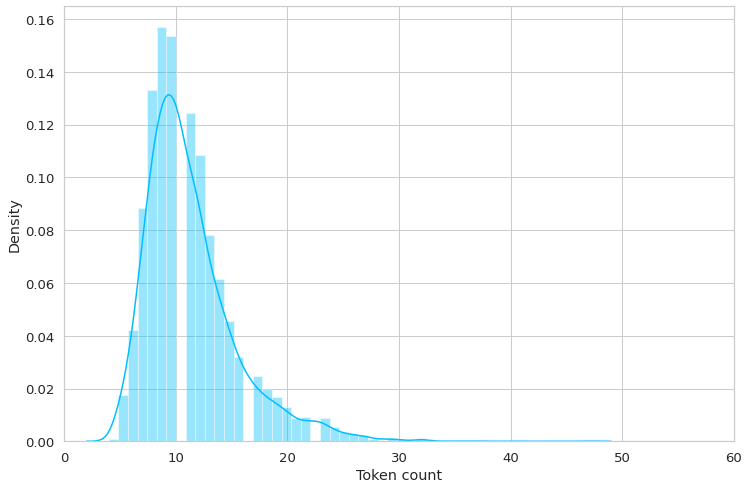

In [8]:
max_len = 0
token_lens = []
for sent in sentences:
  # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
  input_ids = tokenizer.encode(sent, add_special_tokens=True)
  token_lens.append(len(input_ids))
  max_len = max(max_len, len(input_ids))
print(f'Max sentence length: ', max_len)

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12,8

sns.distplot(token_lens)
plt.xlim([0,60])
plt.xlabel('Token count')





##############################


In [9]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
for sent in sentences:
  # `encode_plus` will:
  #   (1) Tokenize the sentence.
  #   (2) Prepend the `[CLS]` token to the start.
  #   (3) Append the `[SEP]` token to the end.
  #   (4) Map tokens to their IDs.
  #   (5) Pad or truncate the sentence to `max_length`
  #   (6) Create attention masks for [PAD] tokens.
  encoded_dict = tokenizer.encode_plus(sent, add_special_tokens=True, max_length=64, pad_to_max_length= True,
                                       return_attention_mask=True, truncation = True, return_tensors='pt')
  input_ids.append(encoded_dict['input_ids'])
  attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids,dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels=torch.tensor(labels)
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])


#######################



/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1773: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  Our friends won't buy this analysis, let alone the next one we propose.
Token IDs: tensor([  101,  2256,  2814,  2180,  1005,  1056,  4965,  2023,  4106,  1010,
         2292,  2894,  1996,  2279,  2028,  2057, 16599,  1012,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [10]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
import numpy as np
import time
import datetime

# Combine the training tokenized samples into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)
# Create a 90-10 train-validation split and calculate the number of samples for both sets.
train_size = int(0.9*len(dataset))
val_size = len(dataset)-train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print(f'Traning sentences {str(train_size)}')
print(f'Validation sentences {str(val_size)}')

batch_size = 32
#DataLoaders for iterators during training
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
validation_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size = batch_size)

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2,output_attentions=False,output_hidden_states=False)
model.cuda() #telling PyTorch to run the model using GPU
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 4
total_steps = len(train_dataloader)*epochs
#Learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Function for calculation accuracy
def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis =1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat==labels_flat)/len(labels_flat)

def format_time(elapsed):
  #return time in hh:mm:ss format
  elapsed_rounded = int(round((elapsed)))
  return str(datetime.timedelta(seconds = elapsed_rounded))
######################



Traning sentences 7695
Validation sentences 856


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [13]:
import random
import numpy as np

seed_val = 42 # to make results reproducible.
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
training_stats = [] #stores training and validation loss, accuracy and timings
total_t0 = time.time() #measures total runtime for training

for epoch in range(epochs):
  print("")
  print('~~~~~~~~~~~~~~~~~~~~~ Epoch {:} / {:} ~~~~~~~~~~~~~~~~~'.format(epoch + 1, epochs))
  t0 = time.time()
  total_train_loss = 0 #reset loss for each epoch
  model.train()
  #for each batch training
  for step,batch in enumerate(train_dataloader):
    if step%40==0 and not step ==0:
      elapsed = format_time(time.time()-t0)
      #progress 
      print('  Batch {:}  of  {:}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels=batch[2].to(device)
    # Clearing previous gradients before a backward pass.
    model.zero_grad()
    loss,logits = model(b_input_ids, token_type_ids=None, attention_mask = b_input_mask, labels=b_labels)
    total_train_loss += loss.item()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)
    optimizer.step()
    # Clip the norm of the gradients to 1.0.
    # This is to help prevent the "exploding gradients" problem.
    scheduler.step() #update learning rate
  avg_train_loss = total_train_loss/len(train_dataloader)
  training_time = format_time(time.time()-t0) #measure how long the epoch took
  print("")
  print("  Average training loss: {0:.2f}".format(avg_train_loss))
  print("  Training epcoh took: {:}".format(training_time))

  #VALIDATION 

  print("")
  print("Running Validation...")

  t0 = time.time()
  model.eval()
  total_eval_accuracy = 0
  total_eval_loss = 0
  nb_eval_steps = 0
  for batch in validation_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels=batch[2].to(device)
    with torch.no_grad():
      (lost, logits) = model(b_input_ids, token_type_ids = None, attention_mask = b_input_mask, labels=b_labels)
    total_eval_loss += loss.item()
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    total_eval_accuracy += flat_accuracy(logits, label_ids)
  avg_val_loss = total_eval_loss/len(validation_dataloader)
  avg_val_accuracy = total_eval_accuracy/len(validation_dataloader)
  validation_time = format_time(time.time()-t0)
  print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
  print("  Validation Loss: {0:.2f}".format(avg_val_loss))
  print("  Validation took: {:}".format(validation_time))

  #record the acquired stats for this epoch
  training_stats.append(
      {
          'epoch':epoch+1, 'Training Loss':avg_train_loss, 'Valid. Loss':avg_val_loss, 'Valid. Accur':avg_val_accuracy,
          'Training Time':training_time, 'Validation Time':validation_time
      }
  )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


#-----------------------------------------




~~~~~~~~~~~~~~~~~~~~~ Epoch 1 / 4 ~~~~~~~~~~~~~~~~~
  Batch 40  of  241.    Elapsed: 0:00:17.
  Batch 80  of  241.    Elapsed: 0:00:34.
  Batch 120  of  241.    Elapsed: 0:00:51.
  Batch 160  of  241.    Elapsed: 0:01:08.
  Batch 200  of  241.    Elapsed: 0:01:25.
  Batch 240  of  241.    Elapsed: 0:01:42.

  Average training loss: 0.23
  Training epcoh took: 0:01:42

Running Validation...
  Accuracy: 0.82
  Validation Loss: 0.21
  Validation took: 0:00:03

~~~~~~~~~~~~~~~~~~~~~ Epoch 2 / 4 ~~~~~~~~~~~~~~~~~
  Batch 40  of  241.    Elapsed: 0:00:17.
  Batch 80  of  241.    Elapsed: 0:00:34.
  Batch 120  of  241.    Elapsed: 0:00:51.
  Batch 160  of  241.    Elapsed: 0:01:08.
  Batch 200  of  241.    Elapsed: 0:01:25.
  Batch 240  of  241.    Elapsed: 0:01:42.

  Average training loss: 0.24
  Training epcoh took: 0:01:43

Running Validation...
  Accuracy: 0.83
  Validation Loss: 0.12
  Validation took: 0:00:03

~~~~~~~~~~~~~~~~~~~~~ Epoch 3 / 4 ~~~~~~~~~~~~~~~~~
  Batch 40  of  241.   

In [14]:
import pandas as pd
pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats
#---------------------------------------


,Training Loss,Valid. Loss,Valid. Accur,Training Time,Validation Time
epoch,,,,,
1,0.23,0.21,0.82,0:01:42,0:00:03
2,0.24,0.12,0.83,0:01:43,0:00:03
3,0.17,0.03,0.83,0:01:43,0:00:03
4,0.14,0.03,0.83,0:01:43,0:00:03


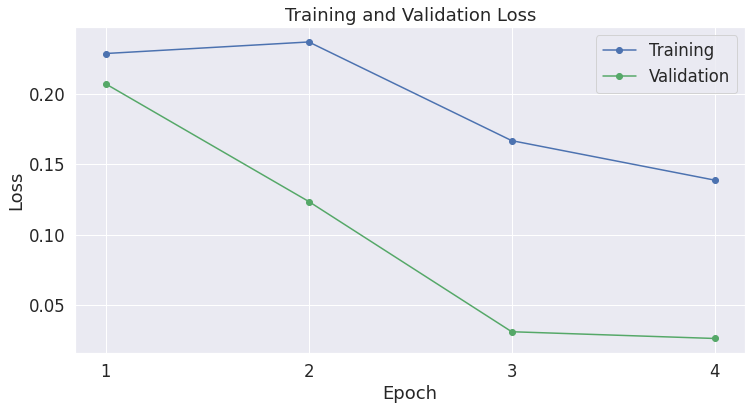

In [15]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1,2,3,4])
plt.show()

#------------------------------------------

In [16]:
# Load the test dataset into a pandas dataframe.
df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
print('Number of test sentences: {:,}\n'.format(df.shape[0]))
sentences = df.sentence.values
labels = df.label.values
input_ids = []
attention_masks=[]

for sent in sentences:
  encoded_dict = tokenizer.encode_plus(sent, add_special_tokens=True, max_length=64, pad_to_max_length=True,
                                       return_attention_mask = True, return_tensors='pt', truncation=True)
  input_ids.append(encoded_dict['input_ids'])
  attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))
model.eval()
predictions, true_labels = [],[]

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch
  with torch.no_grad():
    outputs = model(b_input_ids, token_type_ids=None,attention_mask= b_input_mask)
  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  predictions.append(logits)
  true_labels.append(label_ids)
print('DONE................')


#---------------------------------------------------


Number of test sentences: 516

Predicting labels for 516 test sentences...


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1773: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


DONE................


In [17]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 354 of 516 (68.60%)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


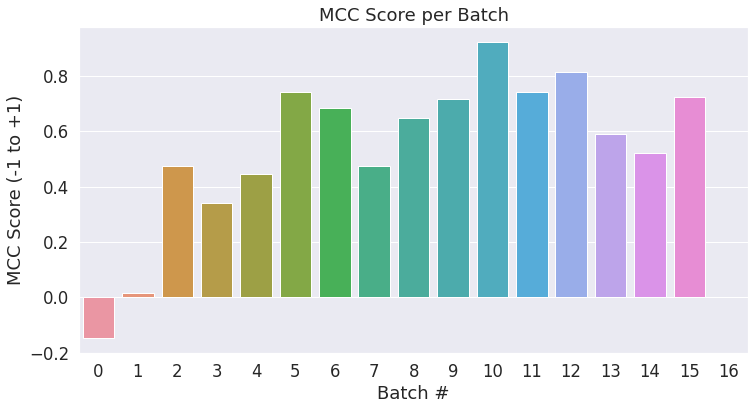

In [20]:
from sklearn.metrics import matthews_corrcoef
matthews_set = []
for i in range(len(true_labels)):
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis = 1).flatten()
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)  # Calculate and store the coef for this batch.  
  matthews_set.append(matthews)

ax = sns.barplot(x=list(range(len(matthews_set))), y = matthews_set, ci=None)
plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')
plt.show()

#---------------------------------------


In [21]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis= 0)
# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)
print('Total MCC: %.3f' % mcc)

Total MCC: 0.566


In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

In [ ]:
# Mount Google Drive to this Notebook instance.
from google.colab import drive
    drive.mount('/content/drive')

In [ ]:
# Load a trained model and vocabulary that you have fine-tuned
model = BertForSequenceClassification.from_pretrained(output_dir)
tokenizer = BertTokenizer.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)